In [1]:
import numpy as np 
import xarray as xr 
import datetime as dt
import matplotlib.pyplot as plt 
from matplotlib.patches import Polygon
import cartopy.crs as ccrs 
import colorcet as ccet 
from scipy import ndimage
from scipy.ndimage import convolve, minimum_filter

from retrieve_era5_fields_nc import *

In [2]:
# Choose a time
dt1 = dt.datetime(2003,10,20,12,0,0)
# dt1 = dt.datetime(2005,12,20,12,0,0)
# dt1 = dt.datetime(2024,2,4,12,0,0)

# plot_area = [125, 315, -60, 60]
# plot_area = [145, 315, -50, 50]
# plot_area = [190, 250, 15, 55]
plot_area = [155, 245, 5, 55]

verbose = True

In [3]:
def get_lpt_composite_mask_file_name(year1):

    year2 = year1 + 1

    data_dir = (
        '/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/'
        + 'lpt-python-public/ar.testing7.merge_split/data/ar/g0_0h/thresh1/systems'
    )

    ymdh1 = f'{year1}060100'
    ymdh2 = f'{year2}063023'

    fn_composite_mask = f'{data_dir}/lpt_composite_mask_{ymdh1}_{ymdh2}.nc'

    return fn_composite_mask


In [4]:
F = retrieve_era5_fields_nc(dt1, verbose=verbose)
lon, lat = np.meshgrid(F['lon'], F['lat'])
tpw = F['tpw']
viwve = F['viwve']
viwvn = F['viwvn']
topography = F['orog']

ivt = np.sqrt(np.power(viwve,2)+np.power(viwvn,2))
area = np.abs(111.0*111.0*0.25*0.25*np.cos(np.pi*lat/180.0))

ivt_filtered = ndimage.gaussian_laplace(ivt, [5,5], truncate=2)

# Deep Tropics Mask and TPW background
fn_ar_mask = ('/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/ar_objects/'
    + dt1.strftime('mask_data.testing7/%Y/%m/ar%Y%m%d%H.nc'))
print(fn_ar_mask)
with xr.open_dataset(fn_ar_mask) as ds:
    deep_tropics_mask = ds['deep_tropics_mask'].data[0,:,:]



mask_ivt = ivt_filtered < -7.0
# Nerf the strong monsoon circulations:
# - Eastward IVT > 500
# - Within deep tropics mask

# mask_ivt[np.logical_and(
#     deep_tropics_mask,
#     viwve > 250.0
#     )] = 0
# mask_ivt[np.logical_and(
#     deep_tropics_mask,
#     viwve < -250.0
#     )] = 0

mask_ivt = ndimage.binary_fill_holes(mask_ivt)


def calc_tpw_background(tpw, topography):
    
    rad = int(5.0/.25)
    MAXTOPO = 500.0
    # MAXTOPO = 1000.0

    if tpw.ndim == 2:

        n_pad_y_lat = 1*rad
        tpw_padded_lat = np.append(tpw[0:n_pad_y_lat,:], tpw, axis=0)
        tpw_padded_lat = np.append(tpw_padded_lat, tpw[-1*n_pad_y_lat:,:], axis=0)
        topo_padded_lat = np.append(topography[0:n_pad_y_lat,:], topography, axis=0)
        topo_padded_lat = np.append(topo_padded_lat, topography[-1*n_pad_y_lat:,:], axis=0)

        #Effectively disregard points above the MAXTOPO elevation.
        tpw_topo_max = np.where(topo_padded_lat > MAXTOPO, 999.0, tpw_padded_lat)

        # Set the shapes used for the minimum filters
        shape_left = np.append(np.ones([1,rad]), np.zeros([1,rad+1]), axis=1)
        shape_right = np.append(np.zeros([1,rad+1]), np.ones([1,rad]), axis=1)
        shape_top = np.append(np.ones([rad,1]), np.zeros([rad+1,1]), axis=0)
        shape_bottom = np.append(np.zeros([rad+1,1]), np.ones([rad,1]), axis=0)

        # Calculate the minimum filters.
        # I'm using "wrap" mode here, but I actually only want it to wrap in the 
        # zonal direction. So I pad it in the meridional direction
        # Then remove the artificial points at the north and south edges.
        tpw_filter_left = minimum_filter(tpw_topo_max, footprint=shape_left, mode='wrap')
        tpw_filter_right = minimum_filter(tpw_topo_max, footprint=shape_right, mode='wrap')
        tpw_filter_top = minimum_filter(tpw_topo_max, footprint=shape_top, mode='wrap')
        tpw_filter_bottom = minimum_filter(tpw_topo_max, footprint=shape_bottom, mode='wrap')

        # Combine the minimum filters to get the full background TPW.
        tpw_filter_left_right = np.maximum(tpw_filter_left, tpw_filter_right)
        tpw_filter_top_bottom = np.maximum(tpw_filter_top, tpw_filter_bottom)

        tpw_filter_all = np.minimum(tpw_filter_left_right, tpw_filter_top_bottom)

        # Throw away the data where I stitched at the north and south edges.
        tpw_filter_all = tpw_filter_all[n_pad_y_lat:-1*n_pad_y_lat,:]

        # I don't have a background TPW for high topography.
        # Therefore, set it to the original TPW.
        # That way when I calculate the difference from the background,
        # I will get zero.
        tpw_filter_all = np.where(tpw_filter_all > 998.0, tpw, tpw_filter_all)

        # Set the background TPW.
        return tpw_filter_all

tpw_background = calc_tpw_background(tpw, topography)


/home/orca/data/model_anal/era5/from_rda/tcwv/e5.oper.an.sfc.128_137_tcwv.ll025sc.2003100100_2003103123.nc
/home/orca/data/model_anal/era5/from_rda/viwve/e5.oper.an.vinteg.162_071_viwve.ll025sc.2003100100_2003103123.nc
/home/orca/data/model_anal/era5/from_rda/viwvn/e5.oper.an.vinteg.162_072_viwvn.ll025sc.2003100100_2003103123.nc
/home/orca/data/model_anal/era5/from_rda/v_200mb/2003/10/e5.oper.an.pl.128_132_v.ll025uv.2003102000_2003102023.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/u_200mb/2003/10/e5.oper.an.pl.128_131_u.ll025uv.2003102000_2003102023.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/invariant/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc
/home/orca/bkerns/projects/mjo_lpt_and_ar/tracking/ar_objects/mask_data.testing7/2003/10/ar2003102012.nc


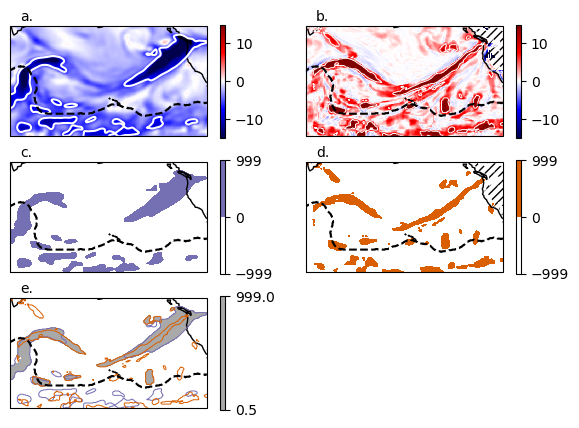

In [5]:
fig = plt.figure(figsize=[7,5])

ax1 = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.set_extent(plot_area, crs=ccrs.PlateCarree())

H1 = ax1.pcolormesh(lon, lat, ivt_filtered, vmin=-15, vmax=15, cmap='seismic', transform=ccrs.PlateCarree())
ax1.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='w', linestyles='-', transform=ccrs.PlateCarree())

plt.colorbar(H1)





# TPW
ax2 = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2.coastlines()
ax2.set_extent(plot_area, crs=ccrs.PlateCarree())

# H2 = ax2.pcolormesh(lon, lat, tpw_background,
#     vmin=0.0, vmax=60.0, cmap='cet_rainbow4', transform=ccrs.PlateCarree())
H2 = ax2.pcolormesh(lon, lat, tpw - tpw_background,
    vmin=-15.0, vmax=15.0, cmap='seismic', transform=ccrs.PlateCarree())

tpw_mask1 = tpw - tpw_background > 10.0
tpw_mask2 = tpw - tpw_background > 0.5*tpw_background
tpw_mask = np.logical_or(tpw_mask1, tpw_mask2)

ax2.contour(lon, lat, tpw_mask,
    levels=[0.5,], colors='w', linewidths=0.7, transform=ccrs.PlateCarree())

plt.colorbar(H2)

ax2.contourf(lon, lat, topography, levels=[1000, 9999], colors=['none',], hatches=['////',], transform=ccrs.PlateCarree())



## Mask showing the final IVT mask

ax3 = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree(central_longitude=180.0))
ax3.coastlines()
ax3.set_extent(plot_area, crs=ccrs.PlateCarree())

# IVT Mask
H3 = ax3.contourf(lon, lat, mask_ivt, levels=[-999.0,0.5,999.0],
    colors = ['none','#7570b3'], transform=ccrs.PlateCarree())

plt.colorbar(H3)

# ax3.contour(lon, lat, viwve, levels=[-250, 250,], colors='r', linestyles='-', transform=ccrs.PlateCarree())

# exclude_ivt_tropics = np.logical_and(deep_tropics_mask, np.abs(viwve) > 250)
# ax3.contourf(lon, lat, exclude_ivt_tropics, levels=[0.5, 9999], colors=['none',], hatches=['////',], transform=ccrs.PlateCarree())



## TPW Mask
ax4 = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4.coastlines()
ax4.set_extent(plot_area, crs=ccrs.PlateCarree())
# # ax2.set_extent([120, 260, 0, 60], crs=ccrs.PlateCarree())
# H = ax3.pcolormesh(lon, lat, ivt_filtered, vmin=-20, vmax=20, cmap='cet_rainbow4', transform=ccrs.PlateCarree())
# ax3.contour(lon, lat, ivt_filtered, levels=[-7.0,], colors='w', linestyles='-', transform=ccrs.PlateCarree())
# ax3.contour(lon, lat, viwve, levels=[250,], colors='r', linestyles='-', transform=ccrs.PlateCarree())

# IVT Mask
H4 = ax4.contourf(lon, lat, tpw_mask, levels=[-999.0,0.5,999.0],
    colors = ['none','#d95f02'], transform=ccrs.PlateCarree())

plt.colorbar(H4)

ax4.contourf(lon, lat, topography, levels=[1000, 9999], colors=['none',], hatches=['////',], transform=ccrs.PlateCarree())


### Combined mask
ax5 = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5.coastlines()
ax5.set_extent(plot_area, crs=ccrs.PlateCarree())

year1 = 2003 #dt1.year
fn_mask = get_lpt_composite_mask_file_name(year1)
with xr.open_dataset(fn_mask) as ds:
    ds_this_time = ds.sel(time=dt1)
    ar_system_mask = ds_this_time['mask'].data


H5 = ax5.contourf(lon, lat, ar_system_mask, levels=[0.5, 999],
    colors=['darkgrey',], transform=ccrs.PlateCarree())

plt.colorbar(H5)


ax5.contour(lon, lat, mask_ivt, levels=[0.5,],
    # colors='#66c2a5', alpha=0.5, transform=ccrs.PlateCarree())
    # colors='#1b9e77', alpha=0.5, transform=ccrs.PlateCarree())
    colors='#7570b3', linewidths=0.7, transform=ccrs.PlateCarree())


# H4 = ax4.contourf(lon, lat, tpw_mask, levels=[-999.0,0.5,999.0],
#     colors = ['none','green'], transform=ccrs.PlateCarree())
ax5.contour(lon, lat, tpw_mask, levels=[0.5,],
    # colors = '#8da0cb', transform=ccrs.PlateCarree())
    # colors = '#7570b3', transform=ccrs.PlateCarree())
    colors = '#d95f02', linewidths=0.7, transform=ccrs.PlateCarree())

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.contour(lon, lat, deep_tropics_mask, levels=[0.5,],
        colors=['k',], linestyles='--', transform=ccrs.PlateCarree())

def add_panel_label(ax, label):
    ax.text(0.05, 1.05, label, transform=ax.transAxes)

add_panel_label(ax1, 'a.')
add_panel_label(ax2, 'b.')
add_panel_label(ax3, 'c.')
add_panel_label(ax4, 'd.')
add_panel_label(ax5, 'e.')

plt.savefig('ivt_and_tpw_mask.png', dpi=150, bbox_inches='tight')
plt.show()